In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from transformers import AutoTokenizer, AutoModelForMaskedLM
from tqdm import tqdm

In [2]:
# define new color palette and make it the default for matplotlib
face_color = "#FFF5E9"
# face_color = "white"
colors = ["#011FFD", "#E12020", "#EE6E26"]
sns.set_palette(sns.color_palette(colors))
plt.rcParams["axes.facecolor"] = face_color

In [3]:
df = pd.read_csv('../DMS_substitutions.csv')
df.head()

,DMS_id,DMS_filename,UniProt_ID,taxon,source_organism,target_seq,seq_len,includes_multiple_mutants,DMS_total_number_mutants,DMS_number_single_mutants,...,MSA_num_significant_L,raw_DMS_filename,raw_DMS_phenotype_name,raw_DMS_directionality,raw_DMS_mutant_column,weight_file_name,pdb_file,ProteinGym_version,raw_mut_offset,coarse_selection_type
0,A0A140D2T1_ZIKV_Sourisseau_2019,A0A140D2T1_ZIKV_Sourisseau_2019.csv,A0A140D2T1_ZIKV,Virus,Zika virus,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,3423,False,9576,9576,...,0.661972,A0A140D2T1_ZIKV_Sourisseau_growth_2019.csv,effect,1,mutant,A0A140D2T1_ZIKV_theta_0.01.npy,A0A140D2T1_ZIKV.pdb,0.1,NaN,OrganismalFitness
1,A0A192B1T2_9HIV1_Haddox_2018,A0A192B1T2_9HIV1_Haddox_2018.csv,A0A192B1T2_9HIV1,Virus,HIV,MRVKGIQMNSQHLLRWGIMILGMIMICSVAGNLWVTVYYGVPVWKD...,852,False,12577,12577,...,2.835714,A0A192B1T2_9HIV1_Haddox_2018.csv,fitness,1,mutant,A0A192B1T2_9HIV1_theta_0.01.npy,A0A192B1T2_9HIV1.pdb,0.1,NaN,OrganismalFitness
2,A0A1I9GEU1_NEIME_Kennouche_2019,A0A1I9GEU1_NEIME_Kennouche_2019.csv,A0A1I9GEU1_NEIME,Prokaryote,Neisseria meningitidis,FTLIELMIVIAIVGILAAVALPAYQDYTARAQVSEAILLAEGQKSA...,161,False,922,922,...,0.521739,A0A1I9GEU1_NEIME_Kennouche_2019.csv,piliation_log2_ratio,1,mutants,A0A1I9GEU1_NEIME_theta_0.2.npy,A0A1I9GEU1_NEIME.pdb,0.1,NaN,Activity
3,A0A247D711_LISMN_Stadelmann_2021,A0A247D711_LISMN_Stadelmann_2021.csv,A0A247D711_LISMN,Eukaryote,Listeria monocytogenes,MNINDLIREIKNKDYTVKLSGTDSNSITQLIIRVNNDGNEYVISES...,87,False,1653,1653,...,2.402299,A0A247D711_LISMN_Stadelmann_2021.csv,mean_prediction,1,mutant,A0A247D711_LISMN_b03_theta_0.2.npy,A0A247D711_LISMN.pdb,1.0,NaN,Activity
4,A0A2Z5U3Z0_9INFA_Doud_2016,A0A2Z5U3Z0_9INFA_Doud_2016.csv,A0A2Z5U3Z0_9INFA,Virus,influenza H1N1,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,565,False,10715,10715,...,1.691042,A0A2Z5U3Z0_9INFA_Doud_2016.csv,transformed_pref,1,mutant,A0A2Z5U3Z0_9INFA_theta_0.01.npy,A0A2Z5U3Z0_9INFA.pdb,0.1,NaN,OrganismalFitness


In [4]:
studies = df['DMS_filename'].map(lambda x: f'../studies/{x}')

# p = torch.multiprocessing.Pool(8)
# all_studies_df = list(tqdm(p.imap(pd.read_csv, studies), total=len(studies)))

In [5]:
def get_max_number_of_mutations(df):
    # count the occurences of a : in the column mutant
    return df['mutant'].str.count(':').max() + 1

In [6]:
# all_studies_max_mutations = list(tqdm(p.imap(get_max_number_of_mutations, all_studies_df, chunksize=1), total=len(all_studies_df)))

In [7]:
def get_one_shot_log_likelihood(model, tokenizer, device, seqs, eps=1e-3):
    model.eval()
    max_length = max([len(seq) for seq in seqs])
    tokenized = tokenizer(seqs, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')

    batch = {k: v.to(device) for k, v in tokenized.items()}
    label = batch['input_ids']
    label_special = torch.zeros_like(label, dtype=torch.bool)
    for special_id in tokenizer.all_special_ids:
        label_special |= label == special_id
    # label = label.masked_fill(label_special, -100)

    with (torch.no_grad(), torch.cuda.amp.autocast(enabled='cuda' in device)):
        # outputs = model(**batch).logits.transpose(1, 2) # [batch_size, num_tokens, seq_len]
        outputs = model(**batch).logits # [batch_size, seq_len, num_tokens]

    # individual_lls = torch.nn.functional.cross_entropy(outputs, label, reduction='none') # [batch_size, seq_len]
    # return -(individual_lls.sum(dim=-1) / (~label_special).sum(dim=-1)).numpy(force=True)
    individual_probs = torch.softmax(outputs, dim=-1).transpose(1, 2) # [batch_size, num_tokens, seq_len]
    individual_probs = individual_probs.gather(dim=1, index=label.unsqueeze(1)).squeeze(1) # [batch_size, seq_len]
    individual_probs = (individual_probs * 2 - 1).clamp(min=eps)
    log_probs = torch.log(individual_probs)
    log_probs = log_probs.masked_fill(label_special, 0)
    return (log_probs.sum(dim=-1) / (~label_special).sum(dim=-1)).numpy(force=True)

In [8]:
device = 'cuda:7'

seqs = df['target_seq'].tolist()
all_lls = {}
model_names = [
    ("facebook/esm2_t48_15B_UR50D", "ESM2 (15B) Log Likelihood"),
    ("facebook/esm2_t36_3B_UR50D", "ESM2 (3B) Log Likelihood"),
    ("facebook/esm2_t33_650M_UR50D", "ESM2 (650M) Log Likelihood"),
    ("facebook/esm2_t30_150M_UR50D", "ESM2 (150M) Log Likelihood"),
    ("facebook/esm2_t12_35M_UR50D", "ESM2 (35M) Log Likelihood"),
    ("facebook/esm2_t6_8M_UR50D", "ESM2 (8M) Log Likelihood"),
]
for hf_model_name, col_name in model_names:
    print(col_name)
    if os.path.exists(f'../wt_probs/{col_name}.pt'):
        all_lls[col_name] = torch.load(f'../wt_probs/{col_name}.pt')[col_name]
    else:
        all_lls[col_name] = []
        model = AutoModelForMaskedLM.from_pretrained(hf_model_name, device_map=device)
        tokenizer = AutoTokenizer.from_pretrained(hf_model_name)
        for seq in tqdm(seqs):
            nlls = get_one_shot_log_likelihood(
                model,
                tokenizer,
                device,
                [seq],
                eps=1e-3
            )
            all_lls[col_name].append(nlls[0])

ESM2 (15B) Log Likelihood
ESM2 (3B) Log Likelihood
ESM2 (650M) Log Likelihood
ESM2 (150M) Log Likelihood
ESM2 (35M) Log Likelihood
ESM2 (8M) Log Likelihood


In [9]:
spearman_df = pd.read_csv('../DMS_substitutions_Spearman_DMS_level.csv')
spearman_df.head()

,DMS ID,Site-Independent,EVmutation,DeepSequence (single),DeepSequence (ensemble),EVE (single),EVE (ensemble),Unirep,Unirep evotuned,MSA Transformer (single),...,CARP (76M),MIF,MIF-ST,ESM-IF1,ProteinMPNN,Number of Mutants,Selection Type,UniProt ID,MSA_Neff_L_category,Taxon
0,A0A140D2T1_ZIKV_Sourisseau_2019,0.383,0.354,0.131,0.103,0.394,0.405,-0.133,0.062,0.475,...,-0.061,-0.061,0.131,0.287,0.129,9576,OrganismalFitness,A0A140D2T1_ZIKV,Medium,Virus
1,A0A192B1T2_9HIV1_Haddox_2018,0.481,0.407,0.413,0.432,0.509,0.516,0.000,0.513,0.514,...,0.429,0.329,0.451,0.206,0.136,12577,OrganismalFitness,A0A192B1T2_9HIV1,Medium,Virus
2,A0A1I9GEU1_NEIME_Kennouche_2019,-0.011,0.044,0.107,0.098,0.053,0.054,-0.024,0.084,0.094,...,-0.043,0.051,0.055,0.039,0.040,922,Activity,A0A1I9GEU1_NEIME,Medium,Prokaryote
3,A0A247D711_LISMN_Stadelmann_2021,0.436,0.459,0.109,0.041,0.428,0.428,0.003,0.026,0.345,...,0.084,0.418,0.441,0.476,0.364,1653,Activity,A0A247D711_LISMN,High,Eukaryote
4,A0A2Z5U3Z0_9INFA_Doud_2016,0.478,0.473,0.484,0.517,0.545,0.548,0.009,0.492,0.164,...,0.017,0.430,0.487,0.462,0.174,10715,OrganismalFitness,A0A2Z5U3Z0_9INFA,Medium,Virus


In [10]:
spearman_df.columns

Index(['DMS ID', 'Site-Independent', 'EVmutation', 'DeepSequence (single)',
       'DeepSequence (ensemble)', 'EVE (single)', 'EVE (ensemble)', 'Unirep',
       'Unirep evotuned', 'MSA Transformer (single)',
       'MSA Transformer (ensemble)', 'ESM-1b', 'ESM-1v (single)',
       'ESM-1v (ensemble)', 'ESM2 (8M)', 'ESM2 (35M)', 'ESM2 (150M)',
       'ESM2 (650M)', 'ESM2 (3B)', 'ESM2 (15B)', 'Wavenet', 'RITA S', 'RITA M',
       'RITA L', 'RITA XL', 'Progen2 S', 'Progen2 M', 'Progen2 Base',
       'Progen2 L', 'Progen2 XL', 'GEMME', 'VESPA', 'VESPAl', 'ProtGPT2',
       'Tranception S no retrieval', 'Tranception M no retrieval',
       'Tranception L no retrieval', 'Tranception S', 'Tranception M',
       'Tranception L', 'TranceptEVE S', 'TranceptEVE M', 'TranceptEVE L',
       'CARP (38M)', 'CARP (600K)', 'CARP (640M)', 'CARP (76M)', 'MIF',
       'MIF-ST', 'ESM-IF1', 'ProteinMPNN', 'Number of Mutants',
       'Selection Type', 'UniProt ID', 'MSA_Neff_L_category', 'Taxon'],
      dtype

In [11]:
for col_name in all_lls:
    spearman_df[col_name] = all_lls[col_name]

In [12]:
# calculate spearman
from scipy.stats import spearmanr, pearsonr

# dictionary to be turned into a DataFrame
correlations = {}
unique_tasks = spearman_df["Selection Type"].unique()
for col_name in all_lls:
    print(col_name)
    s = spearmanr(spearman_df[col_name], spearman_df[col_name[:col_name.find(')')+1]])
    r = pearsonr(spearman_df[col_name], spearman_df[col_name[:col_name.find(')')+1]])
    correlations[f"{col_name[:col_name.find(')')+1]}"] = (s.correlation, r.correlation)


ESM2 (15B) Log Likelihood
ESM2 (3B) Log Likelihood
ESM2 (650M) Log Likelihood
ESM2 (150M) Log Likelihood
ESM2 (35M) Log Likelihood
ESM2 (8M) Log Likelihood


In [13]:
correlations

{'ESM2 (15B)': (-0.003256371666284929, 0.16748428336742904),
 'ESM2 (3B)': (0.1916287110420199, 0.3525578523823336),
 'ESM2 (650M)': (0.37113459874713256, 0.4918002579437554),
 'ESM2 (150M)': (0.5412534432434546, 0.5795320335743002),
 'ESM2 (35M)': (0.6450314127859976, 0.623032569189691),
 'ESM2 (8M)': (0.5019677283216248, 0.5114268589368052)}

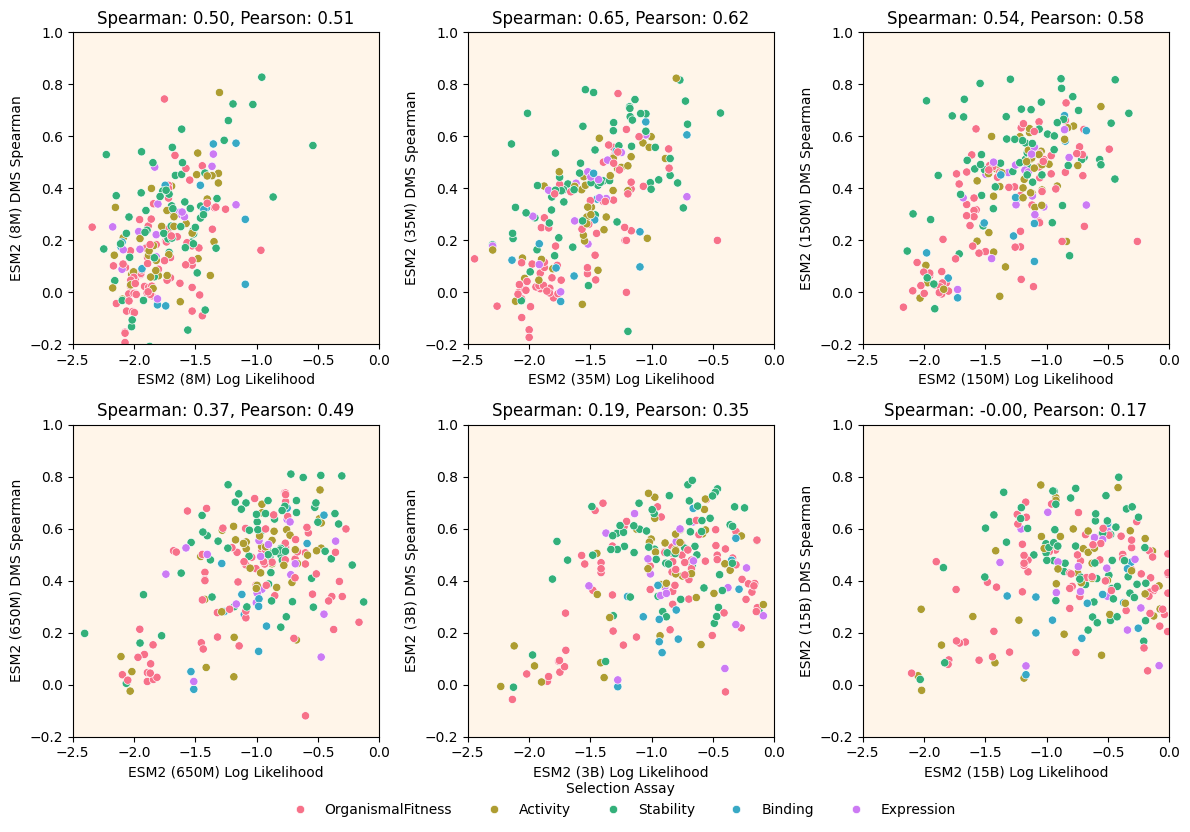

In [14]:
s = 2/3
plt.figure(figsize=(18 * s, 12 * s))
# plot all 4 models side by side
for i, col_name in enumerate(list(all_lls.keys())[::-1]):
    plt.subplot(2, 3, i+1)
    sns.scatterplot(data=spearman_df, x=col_name, y=col_name[:col_name.find(')')+1], hue="Selection Type")
    plt.xlim(-2.5, 0)
    plt.ylim(-0.2, 1)
    plt.ylabel(f"{col_name[:col_name.find(')')+1]} DMS Spearman")
    plt.xlabel(col_name)
    plt.title(f"Spearman: {correlations[col_name[:col_name.find(')')+1]][0]:.2f}, Pearson: {correlations[col_name[:col_name.find(')')+1]][1]:.2f}")
    # hide the legend for all but the third plot
    plt.legend().remove()

# add legend for whole figure
plt.tight_layout()
plt.subplot(2, 3, 5)
plt.legend(title="Selection Assay", loc='center', bbox_to_anchor=(0.5, -0.2), ncol=6, frameon=False)


In [15]:
# get average spearmans for each model and put in a dataframe
model_names = [
    "ESM2 (8M)",
    "ESM2 (35M)",
    "ESM2 (150M)",
    "ESM2 (650M)",
    "ESM2 (3B)",
    "ESM2 (15B)",
]
model_spearman = [spearman_df[i].mean() for i in model_names]
print(model_spearman)


[0.20559907834101385, 0.31882949308755765, 0.4005576036866359, 0.4382119815668203, 0.4321152073732719, 0.4252580645161291]


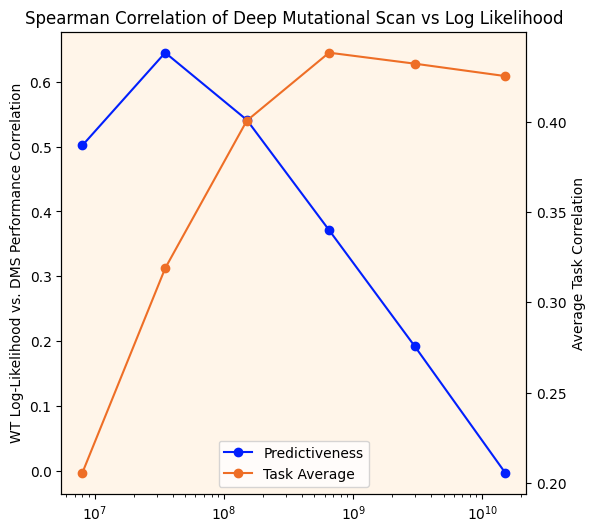

In [16]:
# plot of "meta correlation" vs param count
plt.figure(figsize=(6, 6))
params = [8_000_000, 35_000_000, 150_000_000, 650_000_000, 3_000_000_000, 15_000_000_000]
line1, = plt.plot(params[::-1], [correlations[col_name[:col_name.find(')')+1]][0] for col_name in all_lls], 'o-', label="Predictiveness")
plt.ylabel("WT Log-Likelihood vs. DMS Performance Correlation")
# get a twinx and plot the model_spearman
ax2 = plt.twinx()
line2, = ax2.plot(params, model_spearman, 'o-', color="C2", label="Task Average")
ax2.set_ylabel("Average Task Correlation")
plt.xlabel("Parameters")
plt.title("Spearman Correlation of Deep Mutational Scan vs Log Likelihood")
plt.xscale('log')
# add a combined legend for both plots
lines = [line1, line2]
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, loc='lower center')
plt.gca().get_legend().get_frame().set_facecolor('white')

/tmp/ipykernel_2067522/3702433648.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


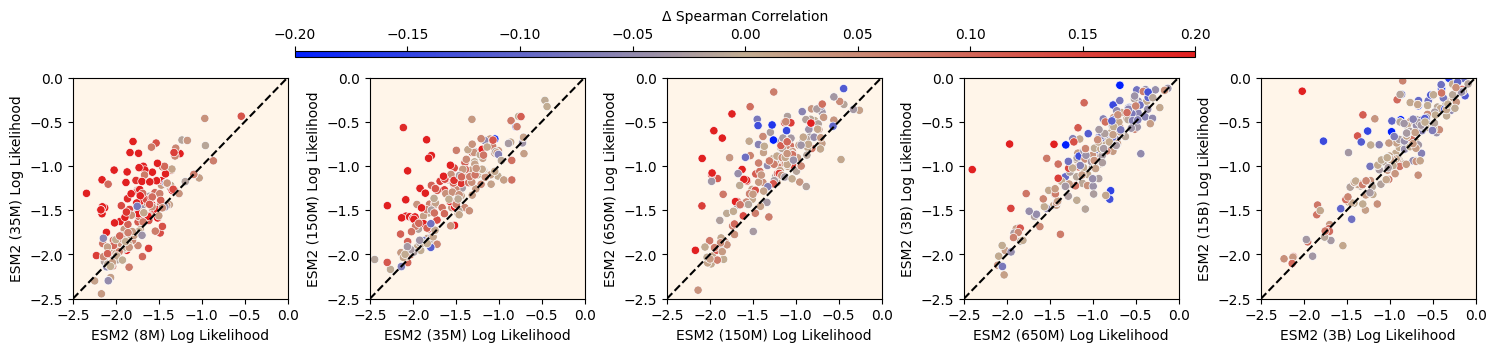

In [17]:
# make 5 plots comparing a model to it's larger counterpart
n = 3
plt.figure(figsize=(5*n, n))

diffs = [spearman_df[model_names[i+1]] - spearman_df[model_names[i]] for i in range(5)]
extreme = max([abs(i).max() for i in diffs])
extreme = 0.2

norm = plt.Normalize(-extreme, extreme)
# make color map from list of colors and not coolwarm
cmap = sns.blend_palette(["#011FFD", "#C2AD92", "#E12020"], as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.gca().set_facecolor(face_color)
    x_axis = model_names[i] + " Log Likelihood"
    y_axis = model_names[i+1] + " Log Likelihood"
    plt.xlim(-2.5, 0)
    plt.ylim(-2.5, 0)
    # plot y = x line using axline
    plt.axline((0, 0), (1, 1), color='black', linestyle='--')
    sns.scatterplot(data=spearman_df, x=x_axis, y=y_axis, c=diffs[i], cmap=cmap, norm=norm)

# add a colorbar at the top of the figure
cax = plt.axes([0.2, 1, 0.6, 0.02])
cbar = plt.colorbar(sm, cax, orientation='horizontal', pad=0.2)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.set_xlabel("Δ Spearman Correlation", labelpad=5)
cbar.ax.xaxis.set_label_position('top')
plt.tight_layout()

In [18]:
# save the spearman df
spearman_df.to_csv('spearman_df_with_ll.csv', index=False)